In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


# Poetry Analysis

Poetry is a cultural treasure of a country and its trademark. It's not unheard of people learning a new language specifically to be able to read poems in the original. While some aspects of a poem are challenging to analyze (e.g. intertexuality, themes and motifs), other characteristics are extractable and quantifiable? 

This capstone project responds to these questions using the English poetry data set which is available at: https://www.kaggle.com/ultrajack/poetry-analysis-using-ai-machine-learning/data. 

The current project accomplishes four tasks:

- A: Prediction of a poem's time period (Renaissance vs. Modern) based on features generated through tf idf scores and subsequent latent semantic analysis (lsa). 
- B: Prediction of a poem's time period (Renaissance vs. Modern) based on word2vec features.
- C: Prediction of a poem's type (love vs. non-love) using tf idf scores and lsa.
- D: Clustering of the Texts using MeanShift, KMeans, and Spectral clustering algorithms.

At this stage of the project, an entire poem text was selected as the mimimum unit of analysis. The tools at our disposal (such as SpaCy) allow us to break a text into sentences and paragraphs, however, in reality, sentences and paragraphs rarely mirror such salient structural elements of a poem as poetic lines and stanzas. Retrieval of these elements would require additional preprocessing and was outside of the scope of this short-term project. 

In [2]:
# load the downloaded dataset
poetry = pd.read_csv('https://github.com/innawendell/Unsupervised_Learning_Capstone/blob/master/poetry.csv')

In [3]:
# explore what the data looks like
poetry.head()

,author,content,poem name,age,type
0,WILLIAM SHAKESPEARE,Let the bird of loudest lay\r\nOn the sole Ara...,The Phoenix and the Turtle,Renaissance,Mythology & Folklore
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,"Sir Charles into my chamber coming in,\r\nWhen...",An Epilogue to the Above,Renaissance,Mythology & Folklore
2,THOMAS BASTARD,"Our vice runs beyond all that old men saw,\r\n...","Book 7, Epigram 42",Renaissance,Mythology & Folklore
3,EDMUND SPENSER,"Lo I the man, whose Muse whilome did maske,\r\...","from The Faerie Queene: Book I, Canto I",Renaissance,Mythology & Folklore
4,RICHARD BARNFIELD,"Long have I longd to see my love againe,\r\nSt...",Sonnet 16,Renaissance,Mythology & Folklore


Further exploration of the dataset showed that the it contained a significant number of copyright notices in the 'content' column with no actual poem texts. These entries had to be removed from the dataset.

In [4]:
# cleaning function to remove the copyright notices. Tagging the rows with the copyright notices
def copyright(row):
    if row['content'].count('Copyright') >0:
           return 'Copyright'
    elif row['content'].count('copyright') >0:
        return 'Copyright'
    elif row['content'].count('Originally published') >0:
        return 'Copyright'
    elif row['content'].count('permission') >0:
        return 'Copyright'
    else:
        return row['content']

In [5]:
# application of the cleaning function to the 'content' column
poetry['content'] = poetry.apply(copyright, axis=1)

In [6]:
#check how many rows were removed
len(poetry[poetry['content']=='Copyright'])

95

In [7]:
# removal of the rows with the copyright notices from the dataset
poetry = poetry[poetry['content'] != 'Copyright']

In [8]:
#reset index after deleting entries
poetry = poetry.reset_index(drop=True)

In [9]:
#check the final shape of the dataset
poetry.shape

(478, 5)

In [10]:
# check if the dataset has any null values. We are not going to handle the null values in the poem name 
# because we are not actually using poem names for our analysis. However, this could be an interesting study in its own
# right: predicting time-period and topic based on the poem name.


poetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 5 columns):
author       478 non-null object
content      478 non-null object
poem name    476 non-null object
age          478 non-null object
type         478 non-null object
dtypes: object(5)
memory usage: 18.8+ KB


If we examine the author composition of the data, it becomes apparenet that William Shakespeare, John Donne, Sir Philip Sidney, and Edmund Spence by far dominate the dataset.

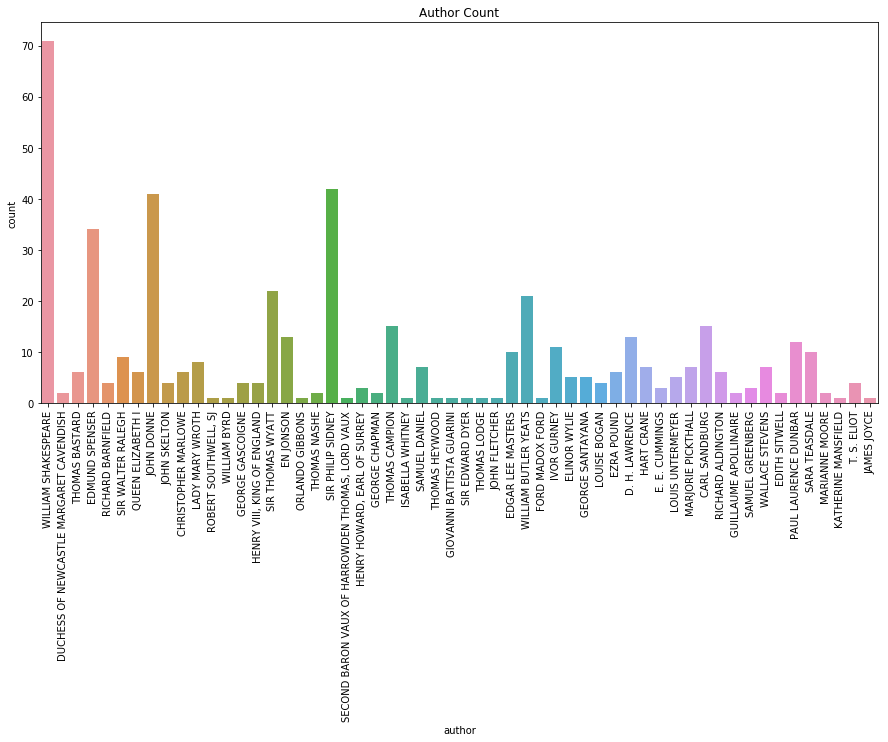

In [11]:
# create a count plot to see how many entries we have for each author

plt.figure(figsize=(15,7))
ax = sns.countplot(x=poetry['author'])
plt.xticks(rotation=90)
plt.title('Author Count')
plt.show()

Additionally, we can clearly see that we have a lot more poems from the Renaissance time period and many more poems about love than about other subjects. This sharp class imbalance ultimately prompted us to classify love vs. non-love poems. 

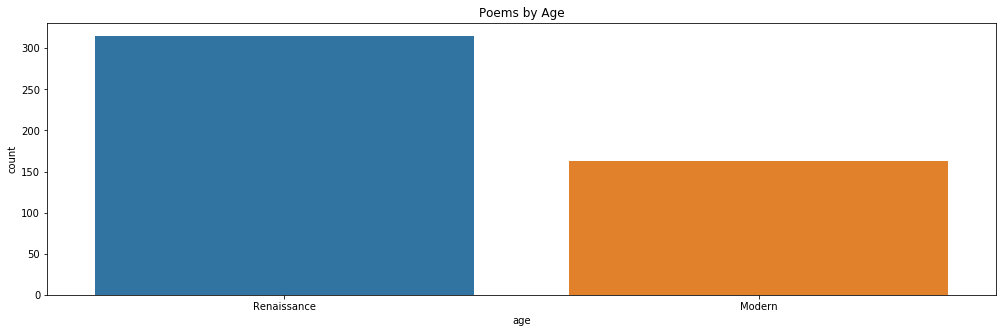

In [12]:
plt.figure(figsize=(17,5))

sns.countplot(x=poetry['age'])
plt.title('Poems by Age')
plt.show()


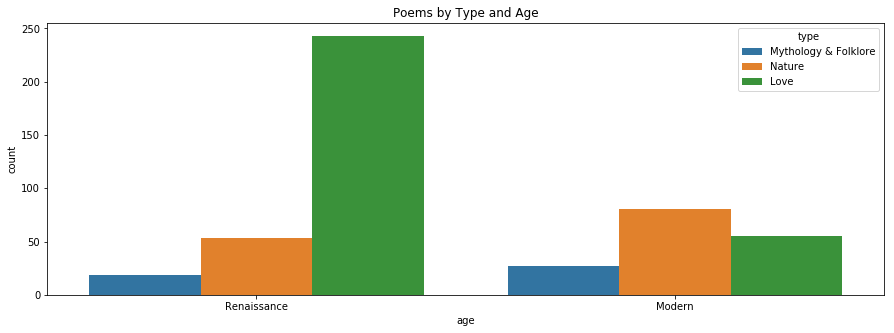

In [13]:
# create count plots for poetry age and type

plt.figure(figsize=(15,5))

sns.countplot(x=poetry['age'], hue=poetry['type'])
plt.title('Poems by Type and Age')
plt.show()

# TASK A. PREDICTION OF THE TIME PERIOD (TF_IDF, LSA)

Our first task is predict the time period when a poem was written: Renaissance vs. Modern. 

# I. Splitting The Data Into Training and Test Sets

We will split our dataset into the train and test sets: 30% of our data will be reserved for testing our algorithms.

In [14]:
# we will keep the fields 'author', 'age', and 'type' in the X here because they will be useful for cluster analysis
# for the actual supervised machine learning algorithms, we will only use the 'content' as the X (see 
# the processor function below)


X = poetry[['content', 'author', 'age', 'type']]

# y will be the 'age' since here we are trying to predict the time period
y = poetry['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#check the length of our train set
len(X_train)

334

In [15]:
#check the length of our test set
len(X_test)

144

# II. Poem Preprocessing

In [16]:
# function for preprocessing the text, including lemmatization and punctuation removal

nlp = spacy.load('en')
def processor(dataframe, column):
    poems_lemmas = []
    for entry in dataframe[column]:
        entry_parsed = nlp(entry)
        string = ''
        for token in entry_parsed:
            if not token.is_punct:
                string += token.lemma_ + ' '
        poems_lemmas.append(string)
    
    # removing new lines marking
    cleaned_poems = []
    for entry in poems_lemmas:
        entry = entry.replace('\n', '')
        cleaned_poems.append(entry)
        
    # removing 'r' marking
    cleaned_poems_fin = []
    for entry in cleaned_poems:
        entry = entry.replace('\r', '')
        cleaned_poems_fin.append(entry) 
    return cleaned_poems_fin

In [17]:
# applying the preprocessing function to the content: now our features include only the processed lemmatized text

X_train_processed = processor(X_train, 'content')

In [18]:
# check what a random example looks like
X_train_processed[100]

"twice or thrice have -PRON- lov'd thee  before -PRON- know thy face or name  so in a voice so in a shapeless flame  angels affect -PRON- oft and worshipp'd be           still when to where thou wert -PRON- come  some lovely glorious nothing -PRON- do see           but since -PRON- soul whose child love be  take limb of flesh and else could nothing do           more subtle than the parent be  love must not be but take a body too           and therefore what thou wert and who                  -PRON- bid love ask and now  that -PRON- assume thy body -PRON- allow  and fix -PRON- in thy lip eye and brow  whilst thus to ballast love -PRON- think  and so more steadily to have go  with ware which would sink admiration  -PRON- see -PRON- have love 's pinnace overfraught           ev'ry thy hair for love to work upon  be much too much some fitter must be seek           for nor in nothing nor in thing  extreme and scatt'r bright can love inhere           then as an angel face and wing  of air no

In [19]:
#check the data type of an entry
type(X_train_processed[100])

str

# III. Feature Generation: TF_IDF SCORES

We will first approach the problem of age prediction by parsing by generating features using **tf_idf scores** for the words that appear in our poems. 

This formula below explains how the **idf score** (inverse document frequency) is calculated for each term (t) where N is the total number of documents (in our case, poem texts) and df_t is the document frequency (how many documents/ poems a term appears in).

$$idf_t=log \dfrac N{df_t}$$

The idf_t allows us to identify the terms that are less important than other terms (because they are too frequent in all poems). The last step is to calcuate the **tf_idf** scores. First, we count the term frequency (how often a term appears in a document / an individual poem). This allows us to weigh repeated words/terms more heavily. To get the final tf_idf score, we multiply the term frequency by its idf score:

$$tf idf_{t,d}=(tf_{t,d})(idf_t)$$


This is a way for us to discriminate among the words and weigh more relevant words more heavily. Essentially, we assign more weight to the words that occur many times in a small number of documents/ poems and less weight to the words that appear in most of the documents / poems. It allows us to convert human text into the format which is suitable for machine learning.

In [20]:
# initialize the sklearn tfidfVectorizer 

vectorizer = TfidfVectorizer(max_df=0.8, # drop words that occur in more than 80% the texts
                             min_df=2, # only use words that appear at least two times
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

In [21]:
# apply the tfidfVectorizer to the processed texts

X_train_tfidf=vectorizer.fit_transform(X_train_processed)

print("Number of features: %d" % X_train_tfidf.get_shape()[1])

Number of features: 3204


In [22]:
#check the length of the generated vocabulary
len(vectorizer.vocabulary_)

3204

By now we have a multi-dimensional space where the number of dimensions is equal to the size of the vocabulary of our TFIDF model . As we can see, our space is made up of 3204 dimensions. We made the decision to include only the words that appear at least two times and drop the words that in 80% of the poems. We also exclude all the stop words (the most commonly used words). Each poem text in our dataset is converted into a vector and placed into our vector space. Similarity between poems can be estimated by calculating the cosine of the angle between the poem vectors. 


# IV. Latent Semantic Analysis and Normalization

We will reduce the dimensionality of our matrix by applying Latent Semantic Analysis or (LSA). We can think of LSA as applying Principal Component Analysis (PCA) to a tf_idf term-document matrix. The resultant components are supposed to reflect a topic and each document / poem will receive a score for each topic where the higher scores mean that a topic is more pronounced in the document / poem. Each poem can have more than one topic and therefore can be relevant to more than one lsa component. 

To perform lsa, we will use Single Value Decomposition (SVD) that is handy for sparse matrices (the matrices with many zeros and few non-zero values). SVD stores only non-zero values and, therefore, offers a significant computational boost. We will reduce our feature space to 280 components and normalize the resultant matrix.

In [23]:
# reduce our feature space to 280 components and normalize our training set
svd= TruncatedSVD(280)

#make a pipeline with svd and normalizer
lsa = make_pipeline(svd, Normalizer(copy=False))

# fit and transform our training set
X_train_lsa = lsa.fit_transform(X_train_tfidf)

#check how much variance is explained by the components
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

print("Variance captured by all components:", "%.2f" %total_variance)

Variance captured by all components: 0.97


# V. Application of The Machine Learning Algorithms

We will use and cross-validate the following algorithms to predict the time period of a poem:

1. Logistic Regression with Ridge normalization
2. Random Forest Classifier
3. Gradient Boosting Classifer
4. XGB Classifier
5. Support Vector Machine Classifier

We will use **roc_auc score** (area under the receiver operating characteristic curve) as the measure of the classifiers' performance. It allows us to estimate the ratio of true positives to false positives regardless of our probability threshhold. 

# Cross-Validation on Training Set

### 1. Logistic Regression ('l1' penalty)

Note: fine-tuned logistic regression with Lasso penalty was tested on the training set and test set but it was excluded from the final version of the notebook because it performed worse than ridge for this particular task.

In [24]:
# fine-tune the C scores for the ridge model

scores = []
Cs = []
for value in [0.001,0.01,0.1,1,10,100]:
    lr = LogisticRegression(C=value)
    score = np.mean(cross_val_score(lr, 
                                    X_train_lsa, 
                                    y_train,
                                    scoring='roc_auc'))
    scores.append(score)
    Cs.append(value)

In [25]:
#create a dataframe to evaluate our results

df  =  pd.DataFrame(scores)
df['Cs'] = Cs
df.columns=['scores', 'Cs']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,Cs
0,0.982533,100.000
1,0.980380,10.000
2,0.974886,1.000
3,0.965313,0.100
4,0.936408,0.010
5,0.916442,0.001


### 2. Random Forest Classifier

In [26]:
# fine-tune the number of esimators (trees) in the random forest
scores = []
parameters = []

est_number = [100, 500,700, 1000, 1500] 

for value in est_number:
    rfc = RandomForestClassifier(n_jobs = -1, 
                                 n_estimators = value)
    score = np.mean(cross_val_score(rfc, 
                                    X_train_lsa, 
                                    y_train, n_jobs=-1,
                                    scoring = 'roc_auc'))
    scores.append(score)
    parameters.append(value)

In [27]:
df = pd.DataFrame(scores)
df['params'] = parameters
df.columns=['scores', 'params']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,params
0,0.962083,1500
1,0.961238,700
2,0.958982,1000
3,0.955766,500
4,0.926472,100


In [28]:
# fine-tune the max_depth of a tree
scores = []
parameters = []

depth = [6, 8, 12, 20, 50] 

for value in depth:
    rfc = RandomForestClassifier(n_jobs = -1, 
                                 n_estimators = 1500, 
                                 max_depth = value)
    score = np.mean(cross_val_score(rfc, 
                                    X_train_lsa, 
                                    y_train, n_jobs=-1,
                                    scoring='roc_auc'))
    scores.append(score)
    parameters.append(value)

In [29]:
df = pd.DataFrame(scores)
df['params'] = parameters
df.columns=['scores', 'params']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,params
0,0.962083,50
1,0.962083,20
2,0.961625,12
3,0.960613,8
4,0.958056,6


### 3. Gradient Boosting Classifier

In [30]:
#fine-tune the number of estimators (trees)

scores = []
parameters = []

est_number = [100, 500,700, 1000, 1500] 

for value in est_number:
    gbc = GradientBoostingClassifier(loss = 'deviance',
                                    n_estimators = value)
    
    score = np.mean(cross_val_score(
                        gbc, 
                        X_train_lsa, 
                        y_train,  
                        n_jobs=-1,
                        scoring='roc_auc'))
    
    scores.append(score)
    parameters.append(value)

In [31]:
df = pd.DataFrame(scores)
df['params'] = parameters
df.columns=['scores', 'params']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,params
0,0.949050,500
1,0.949050,700
2,0.949050,1000
3,0.949050,1500
4,0.944491,100


In [32]:
# fine-tune the max_depth of a tree
scores = []
parameters = []

depth = [4, 6, 8, 10] 

for value in depth:
    gbc = GradientBoostingClassifier(loss = 'deviance',
                                    n_estimators = 500,
                                    max_depth = value)
    
    score = np.mean(cross_val_score(
                        gbc, 
                        X_train_lsa, 
                        y_train,  
                        n_jobs=-1,
                        scoring='roc_auc'))
    
    scores.append(score)
    parameters.append(value)

In [33]:
df = pd.DataFrame(scores)
df['params'] = parameters
df.columns=['scores', 'params']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,params
0,0.939058,4
1,0.879748,8
2,0.874769,6
3,0.874295,10


### 4. XGB Classifier

In [34]:
# find an optimal number of estimators 
n_est = []
scores = []

for value in [100, 500, 700, 1000]:
    xgb = XGBClassifier(n_jobs = -1,  
                        n_estimators = value, 
                        booster= 'gbtree')
    score = np.mean(cross_val_score(xgb, 
                                    X_train_lsa, 
                                    y_train, 
                                    n_jobs=-1, 
                                    scoring='roc_auc'
                                   ))
    scores.append(score)
    n_est.append(value)

In [35]:
df_xgb = pd.DataFrame(scores, columns = ['scores'])
df_xgb['n_est'] = n_est
df_xgb.sort_values(by=['scores'], ascending=False)

,scores,n_est
1,0.953927,500
2,0.953927,700
3,0.953927,1000
0,0.949694,100


In [36]:
# find the perfect depth of a tree

max_depth = []
scores = []

for value in [2, 4, 6, 8]:
    xgb = XGBClassifier(n_jobs = -1,  
                        n_estimators = 500, 
                        booster= 'gbtree',
                        max_depth = value)
    score = np.mean(cross_val_score(xgb, 
                                    X_train_lsa, 
                                    y_train, 
                                    n_jobs=-1,
                                    scoring='roc_auc'))
    scores.append(score)
    max_depth.append(value)

In [37]:
df_xgb = pd.DataFrame(scores, columns = ['scores'])
df_xgb['max_depth'] = max_depth
df_xgb.sort_values(by=['scores'], ascending=False)

,scores,max_depth
0,0.954051,2
2,0.945622,6
3,0.945501,8
1,0.944113,4


In [38]:
# find the optimal learning rate

learning_rates = []
scores = []

for value in [0.5, 0.1, 0.01]:
    xgb = XGBClassifier(n_jobs = -1,  
                        n_estimators = 500, 
                        booster= 'gbtree',
                        max_depth = 2,
                       learning_rate = value)
    score = np.mean(cross_val_score(xgb, 
                                    X_train_lsa, 
                                    y_train, 
                                    n_jobs=-1,
                                    scoring='roc_auc'))
    scores.append(score)
    learning_rates.append(value)

In [39]:
df_xgb = pd.DataFrame(scores, columns = ['scores'])
df_xgb['learning_rate'] = learning_rates
df_xgb.sort_values(by=['scores'], ascending=False)

,scores,learning_rate
1,0.954051,0.10
0,0.946036,0.50
2,0.942745,0.01


### 5. Support Vector Machine Classifier

In [41]:
# fine-tune the C value
scores = []
Cs = []
for value in [0.001, 0.01, 0.1, 1, 10, 20, 1e2, 1e3,1e4 ]:
    svc = SVC(C=value, gamma='auto')
    score = np.mean(cross_val_score(svc, 
                                    X_train_lsa, 
                                    y_train,
                                    scoring='roc_auc'
                                    ))
    scores.append(score)
    Cs.append(value)

In [42]:
df  =  pd.DataFrame(scores)
df['Cs'] = Cs
df.columns=['scores', 'Cs']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,Cs
0,0.979470,100.000
1,0.979131,10.000
2,0.979009,20.000
3,0.978890,1.000
4,0.976158,1000.000
5,0.976158,10000.000
6,0.973248,0.100
7,0.959642,0.001
8,0.957002,0.010


In [43]:
# fine-tune the gamma
scores = []
gammas = []
for value in [0.001, 0.01, 0.1, 1, 'auto']:
    svc = SVC(C=1e2, gamma=value)
    score = np.mean(cross_val_score(svc, X_train_lsa, y_train, scoring='roc_auc'))
    scores.append(score)
    gammas.append(value)

In [44]:
df  =  pd.DataFrame(scores)
df['gammas'] = gammas
df.columns=['scores', 'gammas']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,gammas
0,0.980492,1
1,0.979605,0.01
2,0.979470,auto
3,0.979131,0.001
4,0.978926,0.1


# Validation On The Test Set

Now it is time for us evaluate our fine-tuned models on the test set. This will help us decide which algorithms are performing the best.

In [45]:
# repeat the processing for our test set (apply the same function we used for the training set)
X_test_processed = processor(X_test, 'content')

In [46]:
# applying the vectorizer to the test set (this time we use 'transform')
X_test_tfidf=vectorizer.transform(X_test_processed)

In [47]:
# creation of lsa components by applying SVD and the Normalizer (once again we use transform)
X_test_lsa = lsa.transform(X_test_tfidf)

### 1. Logistic Regression (Ridge Normalization)

In [48]:
from sklearn.metrics import roc_auc_score

# initialize the fine-tuned model
lr_test = LogisticRegression(C=1e2)

#fit the model to the training set
lr_test.fit(X_train_lsa, y_train) 

# predict the test set values and calculate roc_auc scores
print(roc_auc_score(y_test, lr_test.predict_proba(X_test_lsa)[:, 1]))

0.9730128610584018


### 2. Random Forest Classifier

In [49]:
# initialize the fine-tuned random forest model
rfc_test = RandomForestClassifier(n_jobs = -1, 
                            n_estimators = 1500, 
                            max_depth = 50)
# fit the model to the training set
rfc_test.fit(X_train_lsa, y_train) 

# predict the test set values and calculate roc_auc scores
print(roc_auc_score(y_test, rfc_test.predict_proba(X_test_lsa)[:, 1]))

0.9525616698292221


### 3. Gradient Boosting

In [50]:
# initialize the fine-tuned gradient boosting classifier
gbc_test = GradientBoostingClassifier(loss = 'deviance',
                                    n_estimators = 500,
                                    max_depth = 4)

# fit the model to the training set
gbc_test.fit(X_train_lsa, y_train) 

# predict the test set values and calculate roc_auc scores
print(roc_auc_score(y_test, gbc_test.predict_proba(X_test_lsa)[:, 1]))

0.9331646637149483


### 4. XGBoost

In [51]:
xgb_test = XGBClassifier(n_jobs = -1,  
                        n_estimators = 500, 
                        booster= 'gbtree',
                        max_depth = 2,
                        learning_rate = 0.1)
# fit the model to the training set
xgb_test.fit(X_train_lsa, y_train)

# predict the test set values and calculate roc_auc scores
print(roc_auc_score(y_test, xgb_test.predict_proba(X_test_lsa)[:, 1]))

0.9243095087497364


### 5. Support Vector Machine Classifier

In [52]:
# initialize the fine-tuned svm classifier
svc_test = SVC(C=1e2, gamma=1, probability=True)

# fit the model to the training set
svc_test.fit(X_train_lsa, y_train) 

# predict the test set values and calculate roc_auc scores
print(roc_auc_score(y_test, svc_test.predict_proba(X_test_lsa)[:, 1]))

0.9778621125869703


The results our models' performance stand as follows:

| Models    |Training Set |Test Set|
|-----------|---|---|
| Logistic Regression (Ridge)     | 0.9825| 0.9726 | 
| Random Forest   | 0.9621| 0.9526 | 
| Gradient Boosting  | 0.9391 | 0.9332 | 
| XGB    | 0.9541 | 0.9243 | 
| SVM    | 0.980 | 0.9779| 

The Logistic Regression with Ridge Normalization and Support Vector Machine Classifer are the top performers. Their test set roc_auc scores were over 97%.

# Task B. Alternative Feature Generation: word2vec

So far, we used the features which were generated from the application of LSA to the tf_idf term-document matrix. We can also try to use an alternative method of feature generation: **word2vec model**. Word2vec is a shallow unsupervised neural network that converts each word into a vector: each word is represented by many neurons and each neuron is involved in representing many words (e.g. one of the aspects of the word 'queen' is the female gender but at the same time the female gender can characterize other words such as 'girl', 'lady' etc.).  Vectors of the words that frequently appear in the same context would end up closer to one another. Proximity, therefore, means proximity of context.

The model creates a vector for each individual word but what we need as an input for our superivsed learning models is one feature vector for each document / poem. One possible solution to this problem is to calculate the sum of the individual word vectors from a poem to arrive at the resultant vector. This is what we will do for our analysis. From the very start, we need to admit the limitions of applying this model to our corpus: in general, word2vec model works the best with a very large corpus. Our corpus is very limited (only 478 texts).

# I. Poem Preprocessing

In [53]:
# Create a transformation function for our current X_train set which we need to convert
# to a different format in order to use word2vec
# so far we have one string for an entire poem but we need each word to be a separate string

def parser(document): 
    doc = nlp(document)
    test_list = []
    for entry in doc:
        if (
            not entry.is_punct
        and not entry.is_stop):
            test_list.append(str(entry.lemma_))
    return test_list

In [54]:
# apply the parser function to each poem in our dataset and save the result in X_mod which now contains 
# the same text but with each word (lemma) as a separate string

X_mod = []
for entry in X_train['content']:
    result = parser(entry)
    X_mod.append(result)

In [55]:
len(X_train['content'])

334

In [56]:
len(X_mod)

334

# II. Application of The Word2Vec Model for Feature Generation

In [57]:
# import the word2vec model in gensim implementation

import gensim
from gensim.models import word2vec

# model parameters picked via experimentation with the cross_val_score on the training set

model = word2vec.Word2Vec(
    X_mod,
    workers=4,     
    min_count=5,   # Minimum word count threshold.
    window=40,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-1 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('done!')

done!


In [58]:
# check the size of our vocabulary
vocab = model.wv.vocab.keys()
print(len(vocab))

1419


In [59]:
# import the normalize function 
from sklearn.preprocessing import normalize


# create a function to add up all the individual word vectors to arrive at the resultant text / poem vector

def result_vector(sentence):
    result = np.zeros(300)
    for word in sentence:
        if word in vocab:
            result+=model.wv[word]
    result = normalize(result.reshape(1, -1)).flatten()        # normalize to avoid any adverse effect of poem length
    return result

In [60]:
# apply the summative function and append all the resultant vectors into X_fin

X_fin = []
for sent in X_mod:
        vec = result_vector(sent)
        X_fin.append(vec)

In [61]:
len(X_fin)

334

# IV. Application of the Machine Learning Algorithms

We will use the following algorithms to predict the time period of a poem:

1. Logistic Regression with Lasso normalization
2. Support Vector Machine Classifier

Once again we will evaluate the algorithms' performance based on the roc_auc scores. 

## Cross-Validation on the Training Set

### 1. Logistic Regression: Lasso Regularization

Note: Ridge regularization was attempted for this problem but it consistently had lower roc_auc scores than lasso regularization. It was excluded from the final version of the notebook.

In [62]:
scores = []
Cs = []
for value in [0.01,0.1,1,10,100, 1e6]:
    lr = LogisticRegression(C=value, penalty='l1', max_iter = 200)
    score = np.mean(cross_val_score(lr, 
                                    X_fin, 
                                    y_train,
                                    scoring='roc_auc'))
    scores.append(score)
    Cs.append(value)

In [63]:
df  =  pd.DataFrame(scores)
df['Cs'] = Cs
df.columns=['scores', 'Cs']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,Cs
0,0.927617,1000000.00
1,0.906988,100.00
2,0.893148,10.00
3,0.869107,1.00
4,0.500000,0.01
5,0.500000,0.10


### 2. Support Vector Machine Classifier

In [65]:
# fine-tuning the C value
scores = []
Cs = []
for value in [0.001, 0.01, 0.1, 1, 10, 20, 1e2, 1e3,1e4 ]:
    svc = SVC(C=value, gamma='auto')
    score = np.mean(cross_val_score(svc, 
                                    X_fin, 
                                    y_train,
                                    scoring='roc_auc'))
    scores.append(score)
    Cs.append(value)

In [66]:
df  =  pd.DataFrame(scores)
df['Cs'] = Cs
df.columns=['scores', 'Cs']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,Cs
0,0.892984,1000.000
1,0.891283,10000.000
2,0.876011,100.000
3,0.869824,1.000
4,0.869581,10.000
5,0.869581,20.000
6,0.868379,0.100
7,0.866566,0.001
8,0.866566,0.010


In [67]:
# fine-tuning the gamma value
scores = []
gammas = []
for value in [0.001, 0.01, 0.1, 1, 'auto']:
    svc = SVC(C=1e3, gamma=value)
    score = np.mean(cross_val_score(svc, 
                                    X_fin, 
                                    y_train, 
                                    scoring='roc_auc'))
    scores.append(score)
    gammas.append(value)

In [68]:
df  =  pd.DataFrame(scores)
df['gammas'] = gammas
df.columns=['scores', 'gammas']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,gammas
0,0.892984,auto
1,0.891463,0.01
2,0.891309,1
3,0.888035,0.001
4,0.883447,0.1


## Validation on the Test Set

In [69]:
# we need to convert our test set into the appropriate format

X_mod_test = []
for entry in X_test['content']:
    result = parser(entry)
    X_mod_test.append(result)

In [70]:
len(X_test)

144

In [71]:
len(X_mod_test)

144

In [72]:
# apply the summative function to the test set and append all the resultant vectors into X_fin_test
X_fin_test = []
for sent in X_mod_test:
    vec = result_vector(sent)
    X_fin_test.append(vec)

### 1. Lasso

In [73]:
# test set validation of our lasso model

lr_test = LogisticRegression(C=1e6, penalty='l1', max_iter = 200)

lr_test.fit(X_fin, y_train)
print(roc_auc_score(y_test, lr_test.predict_proba(X_fin_test)[:, 1]))

0.9576217583807717


### 2. Support Vector Machine Classifier

In [74]:
svc_test = SVC(C=1e3, gamma='auto', probability=True)

svc_test.fit(X_fin, y_train) 

print(roc_auc_score(y_test, svc_test.predict_proba(X_fin_test)[:, 1]))

0.8690702087286528


Performance of the models with word2vec features:

| Models    |Training Set |Test Set|
|-----------|---|---|
| Logistic Regression (Lasso)     | 0.9277| 0.9576 | 
| SVM    | 0.893 | 0.8691| 


Our word2vec model did not perform the best which was to be expected. For this kind of model to work well, we would need a much larger corpus of texts: in our case we only had 573 samples. Using a pretrained model, e.g. Google's, might not be the greatest idea since our corpus contains a very specific vocabulary with a large portion of works dating back to the Renaissance.

# TASK C. Identification of 'Love' Poems

Another task we would like to tackle is to be able to classify poems into two classes: love vs. non-love poems. To accomplish this, we will, first, combine all nature and folklore poems into one class (non-love). We will use the tf_idf lsa features since this approach proved to be more effective than word2vec for this particular data set. We will use the same metric roc_auc score to evaluate our models' performance.

In [75]:
# since we know we are dealing with class imbalance, it is best to convert type into binary features: love vs. not love
poetry['type'] = np.where(poetry['type'] == 'Love', 1, 0)

In [76]:
# We are dealing with imbalanced classes, with love poems dominating the data set. However, previous attempts showed
# that neigher oversampling nor undersampling works well for type prediction. 

poetry.type.value_counts()

1    298
0    180
Name: type, dtype: int64

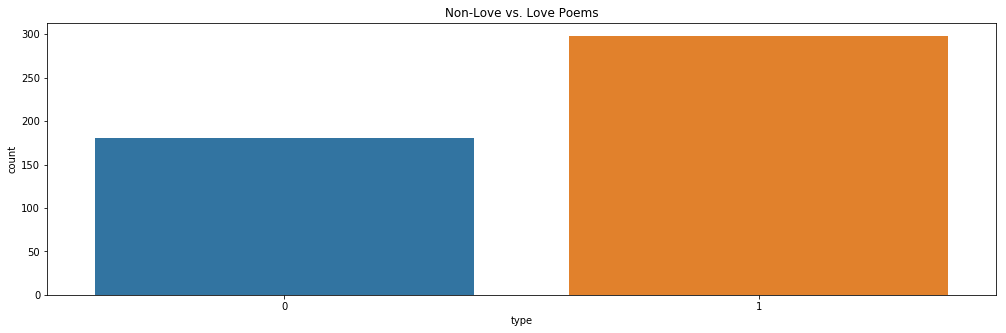

In [77]:
# plot the poems by type

plt.figure(figsize=(17,5))

sns.countplot(x=poetry['type'])
plt.title('Non-Love vs. Love Poems')
plt.show()


# I. Splitting the Data Set Into Training and Test Sets

In [78]:
X_type = poetry[['content']]
y_type = poetry['type'] # this time we are predicting the type, not the age

X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(X_type, y_type, test_size=0.3, random_state=0)

len(X_train_type)

334

In [79]:
y_train_type.value_counts()

1    217
0    117
Name: type, dtype: int64

# II. Preprocessing the Training Set And Feature Generation (TF_IDF LSA)

In [80]:
X_train_type_processed = processor(X_train_type, 'content')

In [81]:
X_train_type_processed[3]

'love in truth and fain in verse -PRON- love to show  that -PRON- dear -PRON- may take some pleasure of -PRON- pain  pleasure may because -PRON- read read may make -PRON- know  knowledge may pity win and pity grace obtain  -PRON- seek fit word to paint the black face of woe  studying invention fine -PRON- wit to entertain  oft turn other leave to see if thence would flow  some fresh and fruitful shower upon -PRON- sunburned brain  but word come halt forth want inventions stay  invention natures child flee step dame studys blow  and other foot still seem but stranger in -PRON- way  thus great with child to speak and helpless in -PRON- throe  bite -PRON- truant pen beat -PRON- for spite  fool say -PRON- muse to -PRON- look in thy heart and write '

In [82]:
X_train_tfidf_type=vectorizer.fit_transform(X_train_type_processed)

print("Number of features: %d" % X_train_tfidf_type.get_shape()[1])

Number of features: 3204


In [83]:
X_train_lsa_type = lsa.fit_transform(X_train_tfidf_type)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Variance captured by all components:", "%.2f" %total_variance)

Variance captured by all components: 0.97


# III. Models Application

## Cross-Validation On The Training Set

### 1. Logistic Regression with Ridge Normalization

In [84]:
scores = []
Cs = []
for value in [0.001,0.01,0.1,1,10,100]:
    lr = LogisticRegression(C=value)
    score = np.mean(cross_val_score(lr, 
                                    X_train_lsa_type, 
                                    y_train_type,
                                    scoring='roc_auc'))
    scores.append(score)
    Cs.append(value)

In [85]:
df  =  pd.DataFrame(scores)
df['Cs'] = Cs
df.columns=['scores', 'Cs']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,Cs
0,0.749311,0.100
1,0.747771,1.000
2,0.723436,0.010
3,0.716087,10.000
4,0.712117,0.001
5,0.698222,100.000


### 2. Support Vector Machine Classifier

In [87]:
scores = []
Cs = []
for value in [0.001, 0.01, 0.1, 1, 10, 20, 1e2, 1e3,1e4 ]:
    svc = SVC(C=value, gamma='auto')
    score = np.mean(cross_val_score(svc, 
                                    X_train_lsa_type, 
                                    y_train_type,
                                    scoring='roc_auc'))
    scores.append(score)
    Cs.append(value)

In [88]:
df  =  pd.DataFrame(scores)
df['Cs'] = Cs
df.columns=['scores', 'Cs']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,Cs
0,0.760187,0.001
1,0.760187,0.010
2,0.730920,20.000
3,0.730328,10.000
4,0.729202,0.100
5,0.728552,1.000
6,0.725483,100.000
7,0.677312,1000.000
8,0.677312,10000.000


In [89]:
scores = []
gammas = []
for value in [0.001, 0.01, 0.1, 1, 'auto']:
    svc = SVC(C=1e-3, gamma=value)
    score = np.mean(cross_val_score(svc, 
                                    X_train_lsa_type, 
                                    y_train_type,
                                    scoring='roc_auc'))
    scores.append(score)
    gammas.append(value)

In [90]:
df  =  pd.DataFrame(scores)
df['gammas'] = gammas
df.columns=['scores', 'gammas']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,gammas
0,0.765456,0.001
1,0.761932,0.01
2,0.760187,auto
3,0.753511,0.1
4,0.708561,1


## Validation on the Test Set

In [91]:
# preprocessing of the test set
X_test_processed = processor(X_test_type, 'content')

In [92]:
# creation of tf_idf features for the test set

X_test_tfidf_type=vectorizer.transform(X_test_processed)

print("Number of features: %d" % X_train_tfidf_type.get_shape()[1])

Number of features: 3204


In [93]:
# application of the Single Value Decomposition model and the normalizer to perform latent semantic analysis (lsa)

X_test_lsa_type = lsa.transform(X_test_tfidf_type)

### 1. Logistic Regression with Ridge Normalization

In [94]:
lr_test = LogisticRegression(C=1e-1)
lr_test.fit(X_train_lsa_type, y_train_type)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [95]:
print(roc_auc_score(y_test_type, lr_test.predict_proba(X_test_lsa_type)[:, 1]))

0.8124632569077013


### 2. Support Vector Machine Classifier

In [96]:
svc_test = SVC(C=1e-3, gamma=1e-3, probability=True)

svc_test.fit(X_train_lsa_type, y_train_type)


SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [97]:
print(roc_auc_score(y_test_type, svc_test.predict_proba(X_test_lsa_type)[:, 1]))

0.8154027042915932


Below are the results for the two models predicting poem type:

| Models    |Training Set |Test Set|
|-----------|---|---|
| Logistic Regression (Lasso)     | 0.7493| 0.812 | 
| SVM    | 0.76 | 0.815| 

Our logistic regression with ridge normalization performed and SVM classifer we were able to achieve roc-auc score of over `0.80` on the test set.

# TASK D. Clustering of The Text

The last task we will undertake will be clustering of the poems based on their text and tf_idf lsa components. We will use the following clustering methods:
 - KMeans Clustering
 - Spectral Clustering
 
 Mean-Shift Clustering was attempted in the experimentation stages of the project but did not prove effective. Therefore, it was removed from the final version of the notebook.

# I. Clustering Solutions

Our clustering solutions will be based on all the lsa components. However, for plotting these solutions in 2D, we will use only the first two components. Our training and test set plots will be helpful for us to check relative stability of the clusters.

## 1. KMeans and Spectral Clustering

### a. Two-Cluster Solution 

In [99]:
from sklearn.cluster import KMeans

# initialize the algorithm

km = KMeans(n_clusters = 2, random_state=10) 

# fit and predict the clusters of the training set
y_pred_km = km.fit_predict(X_train_lsa)

In [100]:
# predict the clusters of the test set
y_pred_km_test = km.predict(X_test_lsa)

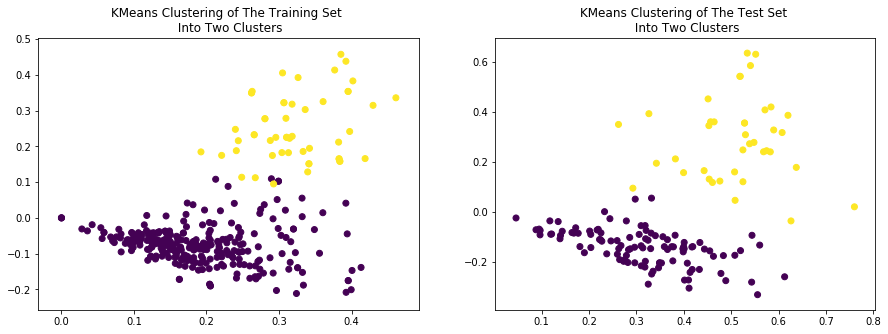

In [101]:
# plot the results of the KMeans Clustering using the first 2 lsa components 
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=y_pred_km)
plt.title('KMeans Clustering of The Training Set \n Into Two Clusters')

plt.subplot(122)
plt.scatter(X_test_lsa[:, 0], X_test_lsa[:, 1], c=y_pred_km_test)
plt.title('KMeans Clustering of The Test Set \n Into Two Clusters')


plt.show()

KMeans produces a consisten two-cluster solution for the training and test sets.

In [102]:
# import the spectral clustering algorithm
from sklearn.cluster import SpectralClustering

# initialize the algorithm
sc = SpectralClustering(n_clusters=2, n_jobs = -1, random_state=10)

# fit and predict the clustering of the training set
sc_pred = sc.fit_predict(X_train_lsa)

In [103]:
# spectral clustering has no 'predict method' so we have to do a new fit_predict on the test set
sc_pred_test = sc.fit_predict(X_test_lsa)

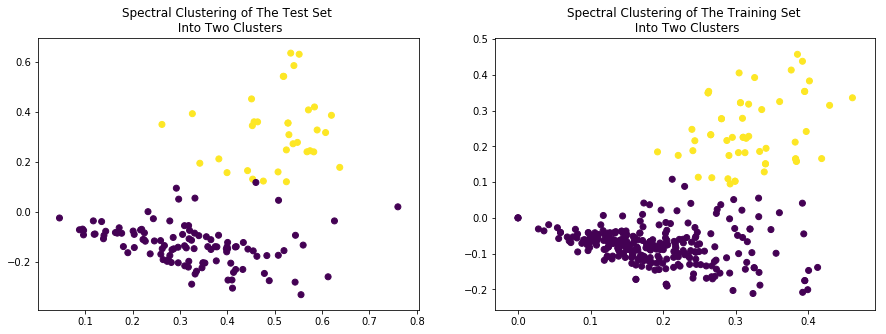

In [104]:
# Plof the results of the spectral clustering using the first two lsa components

plt.figure(figsize=(15,5))

plt.subplot(122)
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=sc_pred)
plt.title('Spectral Clustering of The Training Set \n Into Two Clusters')

plt.subplot(121)
plt.scatter(X_test_lsa[:, 0], X_test_lsa[:, 1], c=sc_pred_test)
plt.title('Spectral Clustering of The Test Set \n Into Two Clusters')


plt.show()

Spectral Clustering algorithm also manages to produce consisten clustering. However, we should note that we cannot use 'predict' on the test set (instead, we are forced to utilize 'fit_predict') and thus we approach the test set as a new clustering problem and create a clustering solution from scratch.

### b. Four-Cluster Solution

In [105]:
# initialize the KMeans algorithm
km_four = KMeans(n_clusters = 4, random_state=10) 

# fit it to the the training set and predict its clustering
y_pred_km_four = km_four.fit_predict(X_train_lsa)

In [106]:
# predict the clustering of the test set
y_pred_km_test_four = km_four.predict(X_test_lsa)

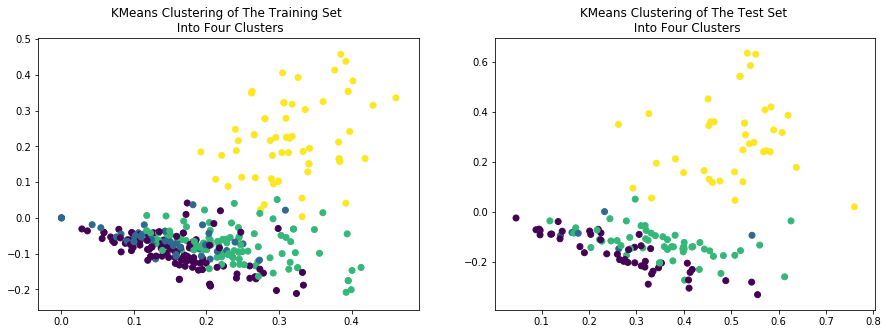

In [107]:
# plot the first two lsa components and its clustering into four clusters by KMeans

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=y_pred_km_four)
plt.title('KMeans Clustering of The Training Set \n Into Four Clusters')

plt.subplot(122)
plt.scatter(X_test_lsa[:, 0], X_test_lsa[:, 1], c=y_pred_km_test_four)
plt.title('KMeans Clustering of The Test Set \n Into Four Clusters')

plt.show()

The clusters look stable. The datapoints overlap points to the fact that they are separated in other dimensions which we are not plotting.

In [108]:
# initialize the spectral clustering algorithm
sc_four = SpectralClustering(n_clusters=4, random_state=10)

# fit it to the the training set and predict its clustering
sc_pred_four = sc_four.fit_predict(X_train_lsa)

In [109]:
# no predict method for spectral clustering, have to apply clustering to a new sample (X_test_lsa)
sc_pred_four_test = sc_four.fit_predict(X_test_lsa)

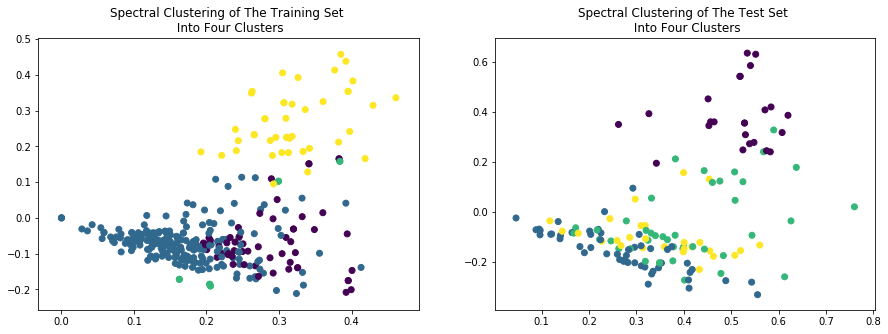

In [110]:
# plot the first two lsa components and its clustering into four clusters by Spectral Clustering
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=sc_pred_four)
plt.title('Spectral Clustering of The Training Set \n Into Four Clusters')

plt.subplot(122)
plt.scatter(X_test_lsa[:, 0], X_test_lsa[:, 1], c=sc_pred_four_test)
plt.title('Spectral Clustering of The Test Set \n Into Four Clusters')

plt.show()

Even though difference in color is the result of a new clustering solution, spectral clustering does not seem to produce a stable four-cluster solution. Therefore, our final investigation of clusters will be based on the KMeans solutions.

In [111]:
# create columns for the assigned clusters 

X_test['labels_kmtwo'] = y_pred_km_test # two-cluster solution
X_test['labels_kmfour'] = y_pred_km_test_four # four-cluster solution

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [112]:
# create columns for the assigned clusters in the training set

X_train['labels_kmtwo'] = km.labels_ # two-cluster solution
X_train['labels_kmfour'] = km_four.labels_ # four-cluster solution

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [113]:
X_train.head()

,content,author,age,type,labels_kmtwo,labels_kmfour
64,"Hark, hark! the lark at heaven's gate sings, \...",WILLIAM SHAKESPEARE,Renaissance,Nature,0,0
159,"Pack, clouds away! and welcome day!\r\nWith ni...",THOMAS HEYWOOD,Renaissance,Love,0,2
208,"When thou must home to shades of underground,\...",THOMAS CAMPION,Renaissance,Love,1,3
81,"Loving in truth, and fain in verse my love to ...",SIR PHILIP SIDNEY,Renaissance,Love,0,1
344,"O sweet everlasting Voices, be still;\r\nGo to...",WILLIAM BUTLER YEATS,Modern,Nature,0,0


# II. Clusters vs. Original Classes

If we compare our newly created clusters with the original classes, we will notice that there is not much overlap. Two-cluster solution separates the poems into the clusters that contain all ages and all types.

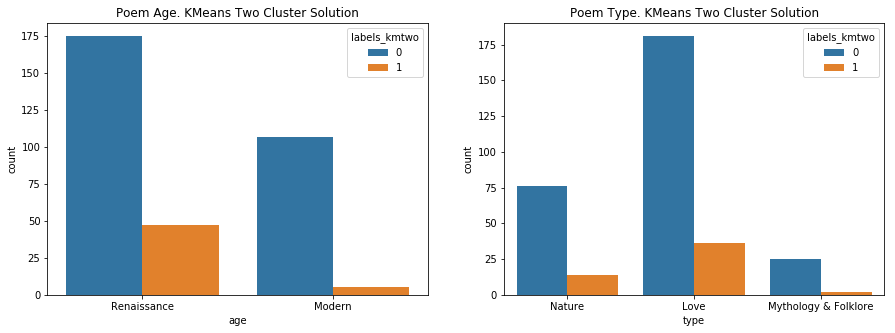

In [114]:
# plot the original time periods (age) and types and clusters

plt.figure(figsize=(15,5))
plt.subplot(121)

sns.countplot('age', data=X_train, hue = 'labels_kmtwo')
plt.title('Poem Age. KMeans Two Cluster Solution')

plt.subplot(122)
sns.countplot('type', data=X_train, hue = 'labels_kmtwo')
plt.title('Poem Type. KMeans Two Cluster Solution')

plt.show()

The four-cluster solution does not look much more promising either. We notice some interesting patterns, e.g. cluster two tends to have more poems from the Renaissance whereas cluster zero has more modern poems. 

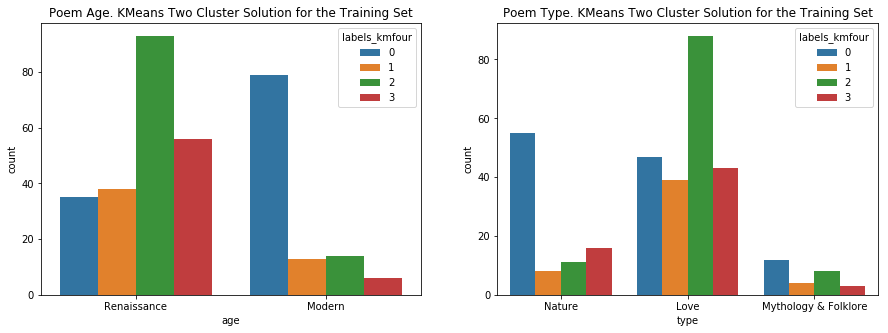

In [115]:
# plot the original time periods (age) and types and clusters

plt.figure(figsize=(15,5))
plt.subplot(121)

sns.countplot('age', data=X_train, hue = 'labels_kmfour')
plt.title('Poem Age. KMeans Two Cluster Solution for the Training Set')

plt.subplot(122)
sns.countplot('type', data=X_train, hue = 'labels_kmfour')
plt.title('Poem Type. KMeans Two Cluster Solution for the Training Set')

plt.show()

# II. Interpretation of the Clustering Solutions

In order for us to acquire a deeper understanding of the clusering solutions, we will need to take a look at the components. We will pick the first five components, since it is unrealistic to look at all 300 of them. 

### a. LSA Components

### 1. LSA Component 0. Celebtration of love and beauty

Our analysis of the top matching poems for the lsa component zero show that these poems portray noble love, beauty, or a maiden in a positive light. 

In [116]:
# we will print the top five poems that have the highest score for component 0

poems_by_component=pd.DataFrame(X_train_lsa,index=X_train['content'])

# print the top scoring poems for this components this way in order to avoid white spaces

print('Component 0: ', poems_by_component.loc[:,0].sort_values(ascending=False)[0:1], '\n', '\n',
        poems_by_component.loc[:,0].sort_values(ascending=False)[1:2], '\n', '\n',
        poems_by_component.loc[:,0].sort_values(ascending=False)[2:3], '\n','\n',
        poems_by_component.loc[:,0].sort_values(ascending=False)[3:4], '\n', '\n',
        poems_by_component.loc[:,0].sort_values(ascending=False)[4:5])

Component 0:  content
If yet I have not all thy love,\r\nDear, I shall never have it all;\r\nI cannot breathe one other sigh, to move,\r\nNor can intreat one other tear to fall;\r\nAnd all my treasure, which should purchase thee\r\nSighs, tears, and oaths, and lettersI have spent.\r\nYet no more can be due to me,\r\nThan at the bargain made was meant;\r\nIf then thy gift of love were partial,\r\nThat some to me, some should to others fall,\r\n         Dear, I shall never have thee all.\r\n\r\nOr if then thou gavest me all,\r\nAll was but all, which thou hadst then;\r\nBut if in thy heart, since, there be or shall\r\nNew love created be, by other men,\r\nWhich have their stocks entire, and can in tears,\r\nIn sighs, in oaths, and letters, outbid me,\r\nThis new love may beget new fears,\r\nFor this love was not vow'd by thee.\r\nAnd yet it was, thy gift being general;\r\nThe ground, thy heart, is mine; whatever shall\r\n         Grow there, dear, I should have it all.\r\n\r\nYet I would

### LSA Component 1. 'Fading'

Top matching poems for the first component describe a woman who undergoes a drastic change. The overarching metaphor: 'fading.'

In [117]:
print('Component 1: ', poems_by_component.loc[:,1].sort_values(ascending=False)[0:10])

Component 1:  content
Look in thy glass and tell the face thou viewest,\r\nNow is the time that face should form another,\r\nWhose fresh repair if now thou not renewest,\r\nThou dost beguile the world, unbless some mother.\r\nFor where is she so fair whose uneared womb\r\nDisdains the tillage of thy husbandry?\r\nOr who is he so fond will be the tomb\r\nOf his self-love, to stop posterity?\r\nThou art thy mothers glass, and she in thee\r\nCalls back the lovely April of her prime;\r\nSo thou through windows of thine age shalt see,\r\nDespite of wrinkles, this thy golden time.\r\n    But if thou live remembred not to be,\r\n    Die single, and thine image dies with thee.                                                                                                                                                                                                                                                                                                                           0.457551

### Component 2. Death

LSA component two portrays death. As we can see, there are some duplicate entries in our dataset. However, due to time constrains, it is not possible for us to remove all the duplicates.

In [118]:
# print this way to avoid white spaces
print('Component 2: ', poems_by_component.loc[:,2].sort_values(ascending=False)[0:1], '\n', '\n',
        poems_by_component.loc[:,2].sort_values(ascending=False)[1:2], '\n', '\n',
        poems_by_component.loc[:,2].sort_values(ascending=False)[2:3], '\n','\n',
        poems_by_component.loc[:,2].sort_values(ascending=False)[3:4], '\n', '\n',
        poems_by_component.loc[:,2].sort_values(ascending=False)[4:5])

Component 2:  content
The ancient songs\r\nPass deathward mournfully.\r\n\r\nCold lips that sing no more, and withered wreaths,\r\nRegretful eyes, and drooping breasts and wings\r\nSymbols of ancient songs\r\nMournfully passing\r\nDown to the great white surges,\r\nWatched of none         - -\r\nSave the frail sea-birds\r\nAnd the lithe pale girls,\r\nDaughters of Okeanos.\r\n\r\nAnd the songs pass\r\nFrom the green land\r\nWhich lies upon the waves as a leaf\r\nOn the flowers of hyacinth;\r\nAnd they pass from the waters,\r\nThe manifold winds and the dim moon,\r\nAnd they come,\r\nSilently winging through soft Kimmerian dusk,\r\nTo the quiet level lands\r\nThat she keeps for us all,\r\nThat she wrought for us all for sleep\r\nIn the silver days of the earth's dawning\r\nProserpine, daughter of Zeus.\r\n\r\nAnd we turn from the Kuprian's breasts,\r\nAnd we turn from thee,\r\nPhoibos Apollon,\r\nAnd we turn from the music of old\r\nAnd the hills that we loved and the meads,\r\nAnd we t

### 3. Component 3: A weak man

In [119]:
# print this way to avoid white spaces
print('Component 3: ', poems_by_component.loc[:,3].sort_values(ascending=False)[0:1], '\n', '\n',
        poems_by_component.loc[:,3].sort_values(ascending=False)[1:2], '\n', '\n',
        poems_by_component.loc[:,3].sort_values(ascending=False)[2:3], '\n','\n',
        poems_by_component.loc[:,3].sort_values(ascending=False)[3:4], '\n', '\n',
        poems_by_component.loc[:,3].sort_values(ascending=False)[4:5])

Component 3:  content
Madam, withouten many words\r\n    Once I am sure ye will or no ...\r\nAnd if ye will, then leave your bourds\r\n    And use your wit and show it so,\r\nAnd with a beck ye shall me call;\r\n    And if of one that burneth alway\r\nYe have any pity at all,\r\n    Answer him fair with & {.} or nay.\r\nIf it be &, {.} I shall be fain;\r\n    If it be nay, friends as before;\r\nYe shall another man obtain,\r\n    And I mine own and yours no more.    0.658182
Name: 3, dtype: float64 
 
 content
Womanhood, wanton, ye want:\r\nYour meddling, mistress, is mannerless;\r\nPlenty of ill, of goodness scant,\r\nYe rail at riot, reckless:\r\nTo praise your port it is needless;\r\nFor all your draff yet and your dregs,\r\nAs well borne as ye full oft time begs.\r\n\r\nWhy so coy and full of scorn?\r\nMine horse is sold, I ween, you say;\r\nMy new furred gown, when it is worn...\r\nPut up your purse, ye shall not pay!\r\nBy crede, I trust to see the day,\r\nAs proud a pea-hen as y

### 4. Component 4: Farewell to love

What unites the top matching poems for this component? They explore the topic of forgotten or fading love. They also often use nature-related metaphors.

In [120]:
print('Component 4: ', poems_by_component.loc[:,4].sort_values(ascending=False)[0:10])

Component 4:  content
If all the world and love were young,\r\nAnd truth in every Shepherds tongue,\r\nThese pretty pleasures might me move,\r\nTo live with thee, and be thy love.\r\n\r\nTime drives the flocks from field to fold,\r\nWhen Rivers rage and Rocks grow cold,\r\nAnd Philomel becometh dumb,\r\nThe rest complains of cares to come.\r\n\r\nThe flowers do fade, and wanton fields,\r\nTo wayward winter reckoning yields,\r\nA honey tongue, a heart of gall,\r\nIs fancys spring, but sorrows fall.\r\n\r\nThy gowns, thy shoes, thy beds of Roses,\r\nThy cap, thy kirtle, and thy posies\r\nSoon break, soon wither, soon forgotten:\r\nIn folly ripe, in reason rotten.\r\n\r\nThy belt of straw and Ivy buds,\r\nThe Coral clasps and amber studs,\r\nAll these in me no means can move\r\nTo come to thee and be thy love.\r\n\r\nBut could youth last, and love still breed,\r\nHad joys no date, nor age no need,\r\nThen these delights my mind might move\r\nTo live with thee, and be thy love.            

### b. Cluster Centers 

 - Two-cluster solution:

In [121]:
# first five lsa components scores of the cluster centers
pd.DataFrame(km.cluster_centers_).iloc[:, :5]

,0,1,2,3,4
0,0.188006,-0.075273,0.004964,0.009982,-0.000164
1,0.323220,0.251585,0.025597,-0.003929,0.017134


- `cluster 0`: the most relvenant components include 0 ('celebration of love and beauty') and 3 ('a weak man'). Component 2 ('death') is somewhat important.

- `cluster 1`: most important components are 0 ('celebration of love and beauty'), 1 ('fading'). Component 4 ('farewell to love') is also relevant. Component 2 ('death') is somewhat important. Component 3 ('a weak man') is not relevant. 

The most obvious differences between the two clusters are connected with component 1 ('fading') which is very important for cluster one and nowhere nearly as important for cluster 0. Additionally, component 3 ('a weak man') is relevant for cluster 0 and significantly less relevant for cluster 1.

 - Four-Cluster Solution:

In [122]:
#first five lsa components of the cluster centers
pd.DataFrame(km_four.cluster_centers_).iloc[:, :5]

,0,1,2,3,4
0,0.159498,-0.093888,0.094870,-0.008463,0.020742
1,0.141093,-0.060234,-0.040414,0.120009,0.011719
2,0.230828,-0.075917,-0.071342,-0.024841,-0.016615
3,0.318519,0.221831,0.025975,0.001821,-0.005481


As we can see, the clusters have significant differences in terms of their underlying poetic themes.:

- `Cluster 0:` somewhat relevant component 0 ('celebration of love and beauty'), component 2 ('death') is important. Component 4 ('farewell to love') is more pertinent to this cluster than to the rest of the clusters.

- `Cluster 1:` somewhat relevant component 0 ('celebration of love and beauty'). Particularly significant component 3 ('a weak man'), also component 4 ('farewell to love'). 

- `Cluster 2:` only component 0 is relevant ('celebration of love and beauty'). This cluster seems to comprise happy and light poems.

- `Cluster 3:` component 0 ('celebration of love and beauty') is more pertinent to this cluster than to any other clusters. The same is true of component 1 ('fading'). Compoent 2('death') is also relevant but not so much as it is in cluster 0.

Clustering helped us uncover groups of data which existed but were not originally apparent to us. While the corpus of the poems used for this analysis was within the established literary cannon, a similar analysis could be applied to a vast corpus of "the great unread" or any other body of texts which had not been previously studied or even read by a human. 

# Conclusions:


This project managed to accomplish the following tasks:
 - compare effectiveness of tf_idf lsa features vs. word2vec features for this particular dataset
 - utilize tf_idf lsa features to:
     - predict time period of a poem with the best roc_auc score of 0.9766.
     - classify poems into two classes (love vs. non-love) with roc_auc score of 0.812.
     - discover clusters in the data and interpret cluster membership based on shared themes.
     
Our corpus was rather small and, therefore, it is not surprising that Latent Semantic Analysis worked better that word2vec which typically requires a very large corpus to perform well. Additionally, it is also important to point out that further fine-tuning of algorithm parameters is possible which is indicated by the fact that the best results were achieved with extreme values. Due to time constraints, this issue was not addressed.